# Analysis of the White Fronted Goose (Anser albifrons) and Associated Subspecies

Author: Waley Wang


In [1]:
#
# Import nessesary libraries and do nessesary non-df related prepwork
#

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


import warnings

import GooseUtils


# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

We start by importing and trimming the relevant data. This notebook focuses only on data related to the Anser albifrons (species id: $1710$) and its subspecies Anser albifrons elgasi (species id: $1719$). This roughly corresponds to $222,322$ rows of data.

In [2]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 1 data from the relevant CSV file
goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_01.csv')

# Filter out all irrelevant species
goose_data_raw = goose_data_raw[(goose_data_raw['SPECIES_ID'] == 1710) | (goose_data_raw['SPECIES_ID'] == 1719)]

In [3]:
#
# Get all relevant columns and display basic information about the data
#

# Retrieve all relevant columns
goose_data = goose_data_raw[['BAND', 
                             'ORIGINAL_BAND', 
                             'OTHER_BANDS', 
                             'EVENT_DATE', 
                             'EVENT_DAY', 
                             'EVENT_MONTH', 
                             'EVENT_YEAR', 
                             'LAT_DD', 
                             'LON_DD', 
                             'COORD_PREC']]

# Display number of non-null entries in each column
print(f'Rows: {goose_data.shape[0]}')

Rows: 222322


## 1: Data Cleaning

Here all irrelevant entries in the data are filtered out and the data is formatted for use.

### 1.1: Formatting Date

A large number of the date cells (~ $3,295$) do not work with the `pd.to_datetime()` function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

1. If the `'EVENT_DATE'` column already has a valid date that works with `pd.to_datetime()`, it will be the date used.
2. Otherwise, if the `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` column all form a date that works with `pd.to_datetime()`, it will be the date used.
3. If neither of the above work, `NaT` will be assigned and the row will be dropped.


The `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` columns are all updated with the relevant information (will be used for grouping later).

In [4]:
#
# Clean time-related columns as described above.
#

# Attempt to apply pd.to_datetime() to the EVENT_DATE column.
goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

# Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns.
dates_from_columns = pd.to_datetime(goose_data['EVENT_MONTH'].apply(str) + '/' + goose_data['EVENT_DAY'].apply(str) + '/' + goose_data['EVENT_YEAR'].apply(str), format='%m/%d/%Y', errors='coerce')

# Fill in all NaT values that can be filled with the guesses from the previous line.
goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

# Remove all rows where EVENT_DATE is still NaT after the above operations.
goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

# Ammend the EVENT_DAY, EVENT_MONTH, and EVENT_YEAR columns based on the EVENT_DATE column.
goose_data['EVENT_DAY'] = goose_data['EVENT_DATE'].apply(lambda x: x.day)
goose_data['EVENT_MONTH'] = goose_data['EVENT_DATE'].apply(lambda x: x.month)
goose_data['EVENT_YEAR'] = goose_data['EVENT_DATE'].apply(lambda x: x.year)

print(f'Rows: {goose_data.shape[0]}')

Rows: 219027


### 1.2: Formatting Coordinates and Deriving a Coordinate Uncertainy

Location data is also vital for analysis, so abit of cleaning will have to be done.

First, rows fitting any of the following conditions will be excluded:
1. Rows that do not have values for either `LAT_DD` or `LON_DD` because this issue cannot be rectified.
2. Rows whose `COORD_PREC` values are `8`, `12`, `18`, `28`, `33`, `38`, `72`, or `NaN` because an uncertainty given either cannot be determined or is too big to be useful (Corresponds to $\sim 1015$ entries).

In [5]:
#
# Clean the coordinates columns as described above.
#

# Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

# Filter out all rows with unusable or useless coordinate precision values as outlined above.
goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                     (goose_data['COORD_PREC'] == 12) | \
                     (goose_data['COORD_PREC'] == 18) | \
                     (goose_data['COORD_PREC'] == 28) | \
                     (goose_data['COORD_PREC'] == 33) | \
                     (goose_data['COORD_PREC'] == 38) | \
                     (goose_data['COORD_PREC'] == 72) | \
                     (goose_data['COORD_PREC'].isna()))]

goose_data = goose_data[(goose_data['LAT_DD'] != 0.0) | (goose_data['LON_DD'] != 0.0)]

print(f'Rows: {goose_data.shape[0]}')

Rows: 218011


Additionally, a new column with lattitude and longitude uncertainties will be made whose values obey the following rules:
1. If the `COORD_PREC` corresponds to an exact location (is `0`), then the uncertainty is $5*10^{6}$ to account for limits in the number of significant digits given by the data.
2. If the `COORD_PREC` corresponds to a 1-minute block (is `1`), then the uncertainty is $\frac{1}{120} \approx 0.01$ degrees (rounded up) since the coordinates are in the centroid of the block.
3. If the `COORD_PREC` corresponds to a 10-minute block (is `10`), then the uncertainty is $\frac{1}{12} \approx 0.1$ degrees (rounded up) since the coordinates are in the centroid of the block.
4. If the `COORD_PREC` corresponds to a 1-degree block (is `60`), then the uncertainty is $0.5$ degrees since the coordinates are in the centroid of the block.
5. If the `COORD_PREC` corresponds to a county (is `7`), then the uncertainty will be $0.25$ degrees by estimate (since the average county land area is 1090.69 degrees and a sqaure of that size is around $0.5$ degrees in lattitude and longitude)
6. If the `COORD_PREC` corresponds to a town/area (is `11`), then the uncertainty will be $0.25$ degrees by estimate (since each town should be smaller than a county and thus have less uncertainty associated with it)

In [6]:
#
# Perform the coordinate precision conversion as described above.
#

# Compute coording uncertainties
goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_unc(x))

# Drop the old column
goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

## 2: Perliminary Analysis

### 2.1: Question 1: Does the White Fronted Goose Move Over the Course of a Year?

In [7]:
#
# Group the data by EVENT_MONTH to prepare for further analysis
#
months_dict = goose_data.groupby('EVENT_MONTH')

# Prepare lists containing lattidue and longitude data from each month
lat_sample = [group['LAT_DD'].values for _, group in months_dict]
lon_sample = [group['LON_DD'].values for _, group in months_dict]

#### 2.1.1: Basic Visual Analysis

Before selecting the tests to answer this question, we first consider plotting data in a relevant format. This would involve plotting how lattitude and longitude change over the course of a year. The result is the following:

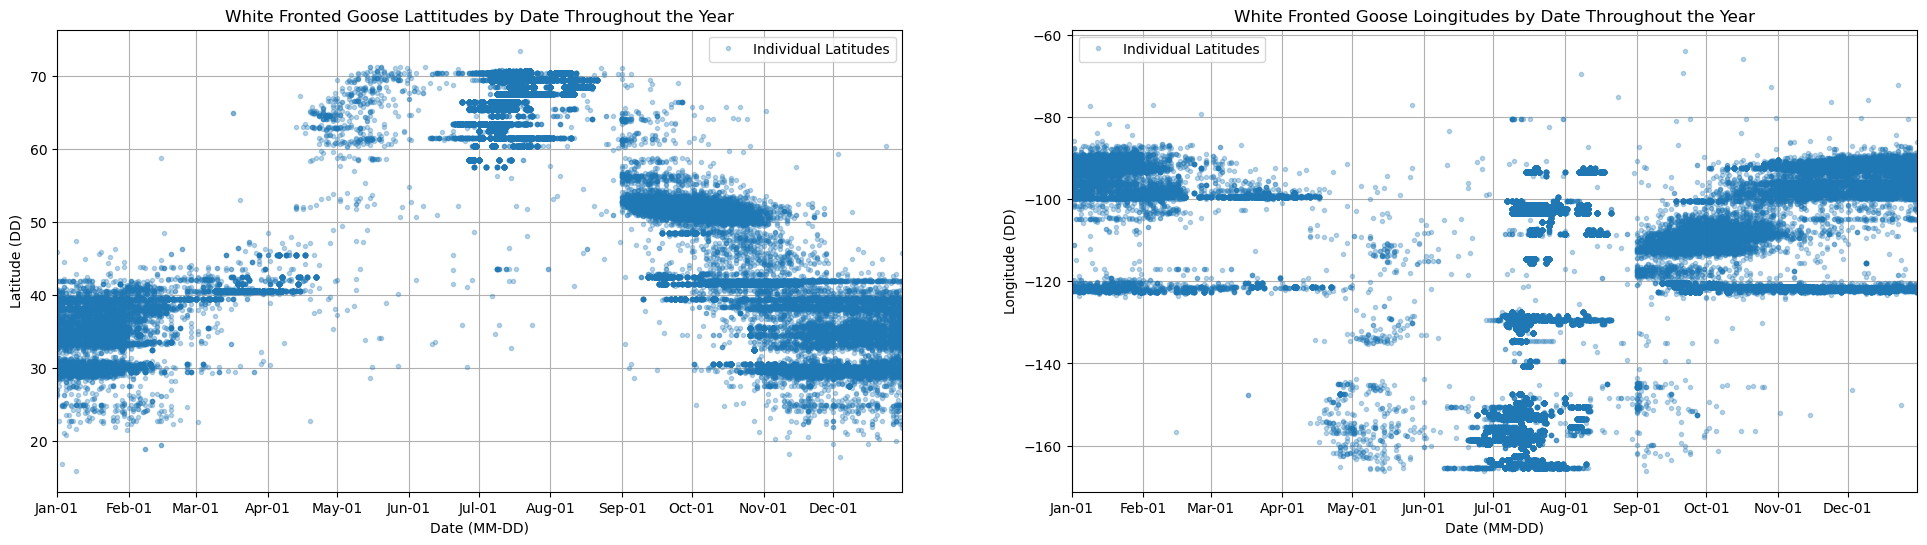

In [12]:
#
# Plot the latitudes and longitudes by date throughout the year
#

def scatter_data(goose_data, goose_name = ''):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 6))
    fmt = mdates.DateFormatter("%b-%d")

    #
    # Plot lattitudes by date excluding the year.
    #
    ax1.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LAT_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax1.xaxis.set_major_formatter(fmt)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax1.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax1.set_xlabel('Date (MM-DD)')
    ax1.set_ylabel('Latitude (DD)')
    ax1.legend()
    ax1.set_title(f'{goose_name} Lattitudes by Date Throughout the Year')
    ax1.grid()

    #
    # Plot longitudes by date excluding the year.
    #
    ax2.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LON_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax2.xaxis.set_major_formatter(fmt)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax2.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax2.set_xlabel('Date (MM-DD)')
    ax2.set_ylabel('Longitude (DD)')
    ax2.legend()
    ax2.set_title(f'{goose_name} Loingitudes by Date Throughout the Year')
    ax2.grid()
    plt.show()

scatter_data(goose_data, 'White Fronted Goose')

There seems to be a significant difference between how locations are distributed throughout the year, but let's verify that first. To do this, let's consider the following method.
1. See if the lattitudes and longitudes of geese differ significantly between months.

The first formulation looks directly at the lattitude and longitude data, and thus will require a test the satisfies the following requirements:
1. The test must be able to compare between more than two samples
2. The test must not require the assumption that the data is normally distributed
3. The test must be able to handle continuous data

### 2.1.2: Direct Analysis of Data (Formulation One)

Before choosing a test, we need to consider if there are any outliers in the lattitude and longitude data. To do this, we make a box plot of the data.

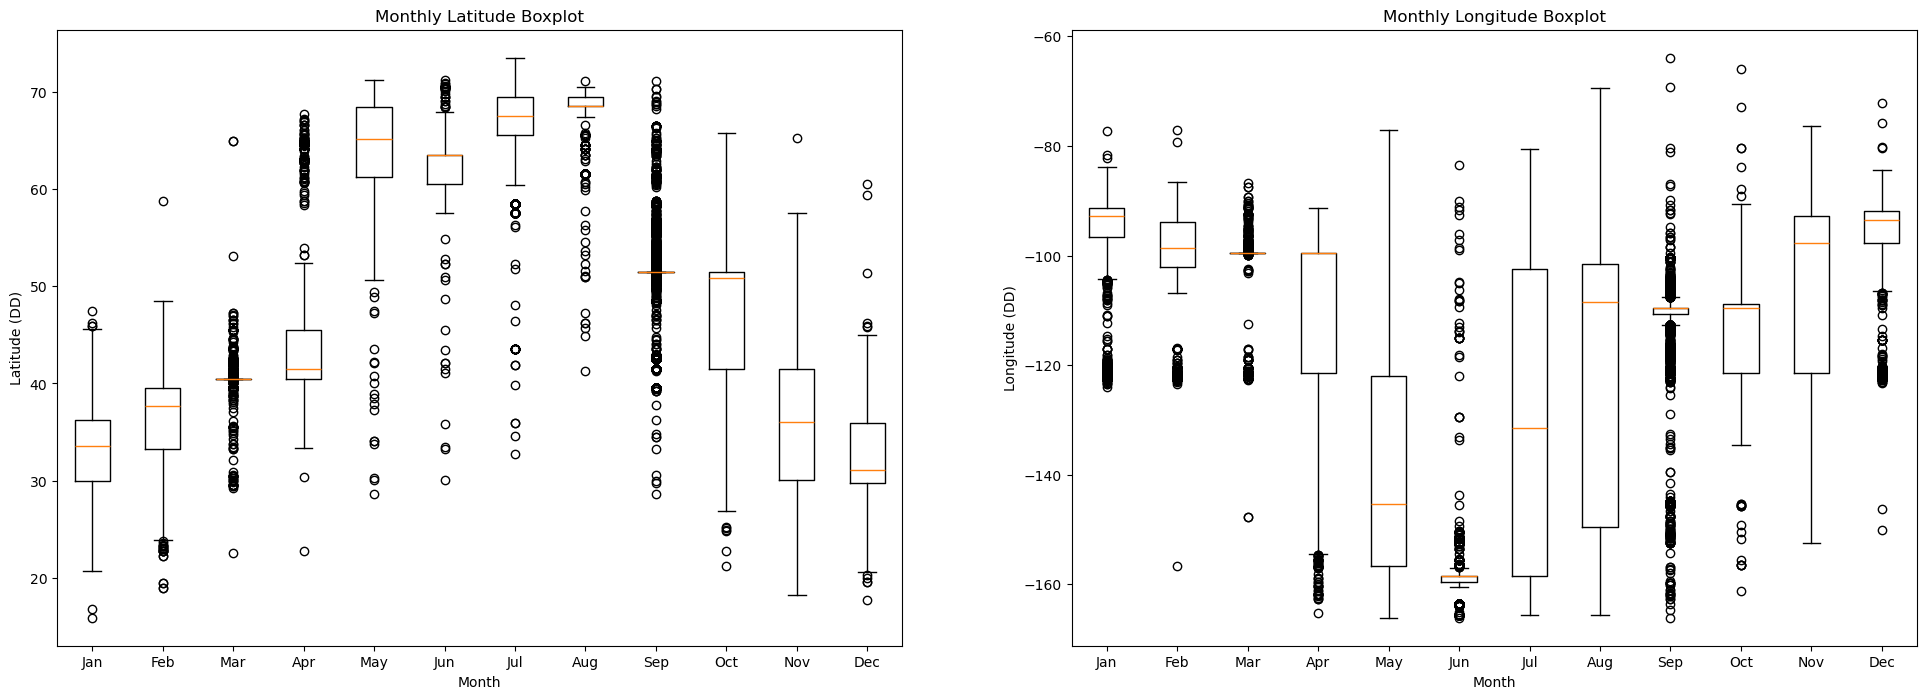

In [9]:
#
# Make boxplots of the latitudes and longitudes by month
#

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.boxplot(lat_sample)
ax1.set_xlabel('Month')
ax1.set_ylabel('Latitude (DD)')
ax1.set_xticklabels(months)
ax1.set_title("Monthly Latitude Boxplot")

ax2.boxplot(lon_sample)
ax2.set_xlabel('Month')
ax2.set_ylabel('Longitude (DD)')
ax2.set_xticklabels(months)
ax2.set_title("Monthly Longitude Boxplot")

plt.show()

It seems we have a large number of outliers in out data, so we also need a test that can handle the presence of outliers.

This means there is one test we should run here. The Mood's Median Test.

#### 2.1.2.1: Mood's Median Testing

For the Mood's Median Test, will compare the median location of the bird over all datapoints taken within each month of the year. The median location here will be defined as the location whose lattitude is the median lattitude and whose longitude is the meadian longitude. We will also define locations being significantly different to mean that either the lattitude or longitude differs significantly.

For this test, we have the following hypotheses:

Null Hypothesis ($H_0$): There is no significant differnce between the median positions (no difference between median lattitude and longitude) of the White Fronted Goose between any two months.

Alternate Hypothesis ($H_A$): This is a significant differnce between the median positions (difference between median lattitude and longitude) of the White Fronted Goose between some pairs of months.

In [10]:
#
# Perform the Mood's Median test on latitude and longitude data
#

# Prepare lists containing lattidue and longitude data from each month
lat_sample = [group['LAT_DD'].values for _, group in months_dict]
lon_sample = [group['LON_DD'].values for _, group in months_dict]

# Perform the Mood's Median test on latitude and longitude data and thank scipy for not making me do it manually
lat_p_value = stats.median_test(*lat_sample).pvalue
lon_p_value = stats.median_test(*lon_sample).pvalue

# Print out the results
print(f"Mood's Median test for lattitude p-value: {lat_p_value}")
print(f"Mood's Median testfor longitude p-value: {lon_p_value}")

Mood's Median test for lattitude p-value: 0.0
Mood's Median testfor longitude p-value: 0.0


As seen above, the Mood's Median $p$ values for both lattitude and longitude are extremely small (both too small for Python to properly store). This means that the median location of the White Fronted Goose differs significantly between at least two months since the $p$ value is clearly smaller than $0.05$, the threshold required to reject the null hypothesis $H_0$. Therefore we can only conclude that $H_A$ is true.

#### 2.1.2.2: Post Hoc Analysis

Since $H_0$ was rejected, a post-hoc analysis is at hand. This will be a series of $\frac{11(11+1)}{2} = 66$ sets of null and alternate hypotheses (denoted as $H_{0, i, j}$ and $H_{A, i, j}$ for $i, j \in \{1, 2, ..., 12 \} | i \neq j$) defined as follows:

Null Hypothesis ($H_{0, i, j}$): The median position in month $i$ does not differ significantly from $j$.

Alternate Hypothesis ($H_{A, i, j}$): The median position in month $i$ differs significantly from $j$.

This will be tested with Mann-Witney U Tests as our data isn't neccesarily normally distributed. The condition for rejecting the null is set to be $p < 0.05$ for either lattitude or longitude.

In [11]:
#
# Perform the Mann-Whitney U test for each pair of months
#

# Initialize a 12x12 matrix to store the results of the Mann-Whitney U test
mann_whitney_results = np.full((12, 12), None, dtype=object)

# Perform the Mann-Whitney U test for each relevant pair of months
for i in range(0, 12):
    for j in range(i + 1, 12):
        lat_stat, lat_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LAT_DD'], months_dict.get_group(j + 1)['LAT_DD'], alternative='two-sided')
        lon_stat, lon_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LON_DD'], months_dict.get_group(j + 1)['LON_DD'], alternative='two-sided')
        mann_whitney_results[i][j] = (lat_stat, lat_p_value, lon_stat, lon_p_value)

# Store the results into a DataFrame for better visualization
mann_whitney_df = pd.DataFrame(mann_whitney_results, index=range(1, 13), columns=range(1, 13))

# Extract the relevant statistics and p-values from the DataFrame
mw_lat_stat_df = mann_whitney_df.map(lambda x: x[0] if x is not None else None)
mw_lat_p_df = mann_whitney_df.map(lambda x: x[1] if x is not None else None)
mw_lon_stat_df = mann_whitney_df.map(lambda x: x[2] if x is not None else None)
mw_lon_p_df = mann_whitney_df.map(lambda x: x[3] if x is not None else None)

# Table whose values correspond to whether the null hypothesis can be rejected for each pair of months
mw_lat_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 if x is not None else None)
mw_lon_h0_reject_df = mann_whitney_df.map(lambda x: x[3] < 0.05 if x is not None else None)
mw_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 and x[3] < 0.05 if x is not None else None)

# Display the results
#     True  -> Reject Null
#     False -> Fail to Reject
#      None -> Not Tested
display(mw_h0_reject_df)

,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,True
2,None,None,True,True,True,True,True,True,True,True,False,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,True,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,False,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


It seems that there is a difference between all pairs of distinct months except for two pairs (September-October and Feburary-November).  Therefore we can conclude that median position of the White Fronted Goose does generally move between months.